This is an example of running code on Rockfish. You need to do the setup first, which I have a tutorial written in "Getting started with the lab". - Billy

In [6]:
import sys, os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow import keras
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import InputLayer, MaxPooling2D, Conv2D, Flatten, Dropout, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow_probability.python.distributions import kl_divergence

In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 30000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 2 Logical GPUs


In [3]:
print(tf.__version__)

2.9.1


In [4]:
n = 10000
t = 2000
v = 2000

In [7]:
hf_train = h5py.File('/data/tuando/data/HSC/HSC_v6/step3A/64x64/5x64x64_training_z_less_than_2_small.hdf5', 'r')
#hf_test = h5py.File('/data/tuando/data/HSC/HSC_v6/step3A/64x64/5x64x64_testing_z_less_than_2_small.hdf5', 'r')
hf_test = h5py.File('/data/tuando/data/CVAE/CVAE_v1/step1/64x64/5x64x64_cvae_generated_2.hdf5', 'r')
hf_validation = h5py.File('/data/tuando/data/HSC/HSC_v6/step3A/64x64/5x64x64_validation_z_less_than_2_small.hdf5', 'r')
x_train = np.asarray(np.transpose(hf_train['image'][0 : ],(0, 2, 3, 1)))
x_test = np.asarray(np.transpose(hf_test['image'][0 : ],(0, 2, 3, 1)))
x_validation = np.asarray(np.transpose(hf_validation['image'][0 : ], (0, 2, 3, 1)))
n = 10000
t = 2000
v = 2000
max_value = 4.16
x_train = np.true_divide(x_train, max_value)
x_test = np.true_divide(x_test, max_value)
x_validation = np.true_divide(x_validation, max_value)
y_train = np.asarray(hf_train['specz_redshift'][0 : ])[..., None]
y_test = np.asarray(hf_test['specz_redshift'][0 : ])[..., None]
y_validation = np.asarray(hf_validation['specz_redshift'][0 : ])[..., None]
hf_train.close()
hf_test.close()
hf_validation.close()

In [8]:
def posterior_mean_field(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype = dtype, initializer = lambda shape, dtype: random_gaussian_initializer(shape, dtype), trainable = True),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc = t[ ..., : n],
                       scale = tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims = 1)),
    ])

def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype = dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc = t, scale = 0.01),
            reinterpreted_batch_ndims = 1)),
    ])

def random_gaussian_initializer(shape, dtype):
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean = 0., stddev = 0.03)
    loc = tf.Variable(
        initial_value = loc_norm(shape = (n, ), dtype = dtype)
    )
    scale_norm = tf.random_normal_initializer(mean = -3., stddev = 0.1)
    scale = tf.Variable(
        initial_value = scale_norm(shape = (n, ), dtype = dtype)
    )
    return tf.concat([loc, scale], 0)

kl_divergence_function = lambda q, p, _: kl_divergence(q, p) / n

In [9]:
model_variational = Sequential([
    InputLayer(input_shape=(64, 64, 5)),
    
    # First Conv block
    tfpl.Convolution2DFlipout(32, kernel_size=(3, 3), activation=None, kernel_divergence_fn=kl_divergence_function),
    BatchNormalization(),
    Activation('relu'),
    tfpl.Convolution2DFlipout(64, kernel_size=(3, 3), activation=None, kernel_divergence_fn=kl_divergence_function),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    # Second Conv block
    tfpl.Convolution2DFlipout(128, kernel_size=(3, 3), activation=None, kernel_divergence_fn=kl_divergence_function),
    BatchNormalization(),
    Activation('relu'),
    tfpl.Convolution2DFlipout(256, kernel_size=(3, 3), activation=None, kernel_divergence_fn=kl_divergence_function),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    # Optional Third Conv block
    tfpl.Convolution2DFlipout(512, kernel_size=(3, 3), activation=None, kernel_divergence_fn=kl_divergence_function),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.2),

    # Dense Variational layer
    tfpl.DenseVariational(128,
                          make_posterior_fn=posterior_mean_field,
                          make_prior_fn=prior_trainable,
                          kl_weight=1/n),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),

    tfpl.DenseVariational(64,
                          make_posterior_fn=posterior_mean_field,
                          make_prior_fn=prior_trainable,
                          kl_weight=1/n),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),

    # Output layer
    Dense(tfpl.IndependentNormal.params_size(1)),
    tfpl.IndependentNormal(1)
])

model_variational.build((10000, 64, 64, 5))
model_variational.summary()

/home/yli21/.conda/envs/photoz/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/home/yli21/.conda/envs/photoz/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_flipout (Conv2DFlipo  (None, 62, 62, 32)       2912      
 ut)                                                             
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 62, 62, 32)        0         
                                                                 
 conv2d_flipout_1 (Conv2DFli  (None, 60, 60, 64)       36928     
 pout)                                                           
                                                                 
 batch_normalization_1 (Batc  (None, 60, 60, 64)       256       
 hNormalization)                                        

In [10]:
def loss_function(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

model_variational.compile(optimizer = Adam(learning_rate = 0.001), loss = loss_function, metrics = [keras.metrics.RootMeanSquaredError()])

In [11]:
model_name = 'bayesian_cnn_rockfish_example'

weights_path = os.path.join('/data/tuando/models/', model_name) + '/weights'

LR_callback = ReduceLROnPlateau()

In [5]:
model_variational.fit(x = x_train, y = y_train, epochs = 60, shuffle = True, verbose = 1, validation_data = (x_validation, y_validation), callbacks = [LR_callback])

NameError: name 'model_variational' is not defined

In [ ]:
model_variational.save_weights(weights_path)

In [12]:
model_variational.load_weights(weights_path)

In [13]:
photoz = []

for i in range(t):
    photoz.append(model_variational(np.array([x_test[i]])).mean()[0][0])

photoz = np.asarray(photoz).astype('float32')

In [14]:
specz = np.asarray(y_test)[ : , 0]

In [15]:
photoz_err = []

for i in range(t):
    photoz_err.append(model_variational(np.array([x_test[i]])).stddev()[0][0])

In [16]:
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([specz, photoz])).astype('float32')
z = gaussian_kde(xy)(xy)

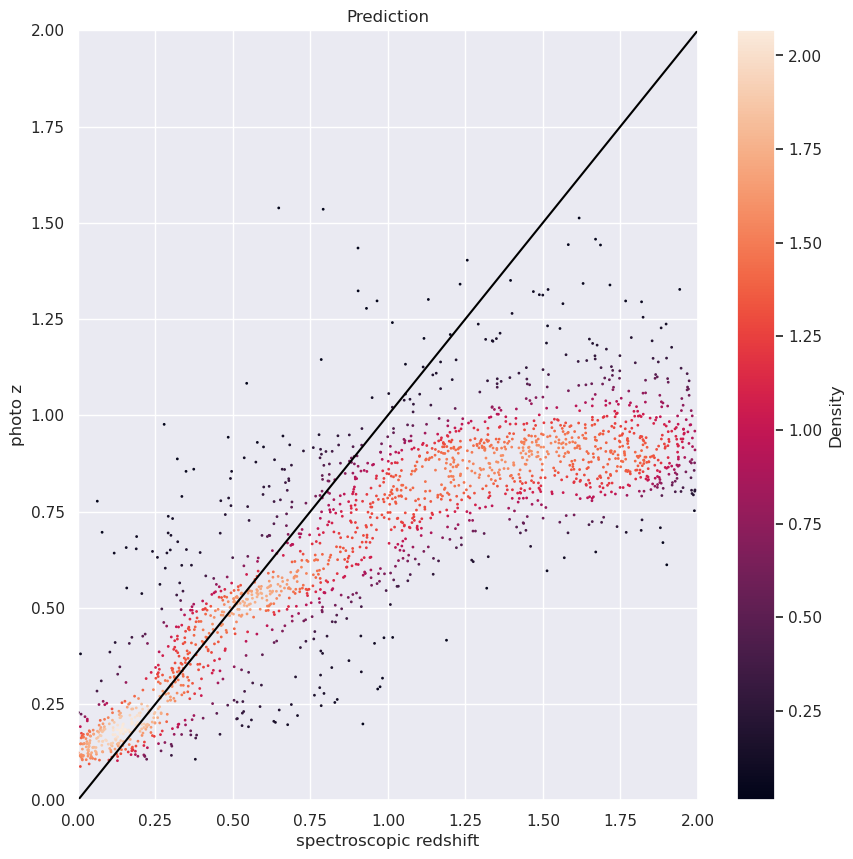

In [17]:
import seaborn as sns
z_max = 2
sns.set(rc = {'figure.figsize' : (10, 10), 'lines.markersize' : 20})
plt.rcParams.update({'font.size' : 40})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(specz, photoz, c = z, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
plt.show()

In [18]:
overlap_variational = 0
overlap_array_variational = []
for i in range(0, t):
    if np.abs(specz[i]-photoz[i]) <= photoz_err[i]:
        overlap_variational += 1
        overlap_array_variational.append(1)
    else:
        overlap_array_variational.append(0)

Coverage: 0.4405


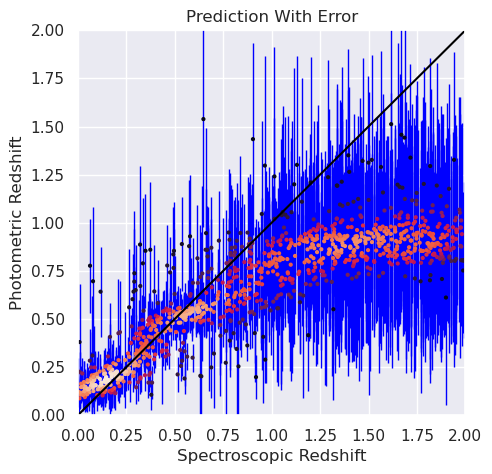

In [19]:
sns.set(rc = {'figure.figsize' : (5, 5), 'lines.markersize' : 40})
plt.rcParams.update({'font.size' : 40})
fig, ax = plt.subplots()
display_size = 1000
scatter_plot = ax.scatter(specz[ : display_size], photoz[ : display_size], c = z[ : display_size], s = 4, edgecolor = None, zorder = 2)
error_plot = ax.errorbar(specz[ : display_size], photoz[ : display_size], yerr = photoz_err[ : display_size], fmt = "o", markersize = 0, color = 'blue', elinewidth = 1, zorder = 1)
plt.title('Prediction With Error')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Photometric Redshift')
plt.plot([0, z_max], [0, z_max], color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
print("Coverage: " + str(overlap_variational / t))

In [20]:
combined_array_variational = np.transpose(np.vstack((specz, photoz, photoz_err, overlap_array_variational))) 

In [21]:
sorted_combined_array_variational = sorted(combined_array_variational, key=lambda x : x[0])

In [22]:
bins_variational = int(z_max * 5)
splitted_sorted_combined_array_variational = np.array_split(sorted_combined_array_variational, bins_variational)
coverage_variational = []
for i in range(0, bins_variational):
    bins_count_variational = 0
    for j in range(0,len(splitted_sorted_combined_array_variational[i])):
        if splitted_sorted_combined_array_variational[i][j][3] == 1:
            bins_count_variational += 1
    coverage_variational.append(bins_count_variational / len(splitted_sorted_combined_array_variational[i]) / 0.6827)
x_array = np.arange(0, z_max, z_max / bins_variational)

Coverage: 0.4405


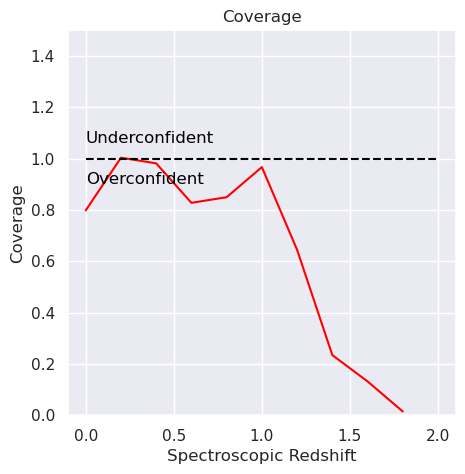

In [23]:
plt.plot(x_array, coverage_variational, c = 'red')
plt.title('Coverage')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Coverage')
plt.ylim([0, 1.5])
plt.plot([0, 2], [1, 1], color = 'black', linestyle = 'dashed')
plt.annotate("Underconfident", xy = (0, 1.06), color = 'black', size = 12)
plt.annotate("Overconfident", xy = (0, 0.9), color = 'black', size = 12)
print("Coverage: "+str(overlap_variational / t))

In [24]:
mean_array = []
for i in range(0, bins_variational):
    total = 0
    for j in range(0, len(splitted_sorted_combined_array_variational[i])):
        bias = (splitted_sorted_combined_array_variational[i][j][1] - splitted_sorted_combined_array_variational[i][j][0]) / (1 + splitted_sorted_combined_array_variational[i][j][0])
        total += bias / (1 + splitted_sorted_combined_array_variational[i][j][0])
    mean_array.append(total / len(splitted_sorted_combined_array_variational[i]))
x_array = np.arange(0, z_max, z_max / bins_variational)

In [25]:
error_array = []
for i in range(0, bins_variational):
    error_total = 0
    for j in range(0,len(splitted_sorted_combined_array_variational[i])):
        error_total += splitted_sorted_combined_array_variational[i][j][2]
    error_array.append(error_total / len(splitted_sorted_combined_array_variational[i]))

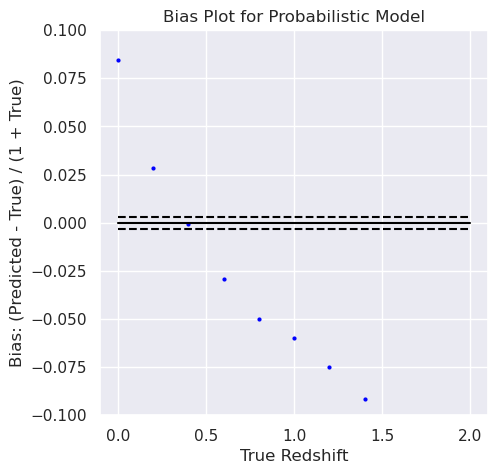

In [26]:
sns.set(rc = {'figure.figsize' : (5, 5), 'lines.markersize' : 40})
plt.rcParams.update({'font.size' : 40})
plt.scatter(x_array, mean_array, marker = 'o', color = 'blue', s = 4)
# plt.errorbar(x_array, mean_array, yerr = error_array, fmt = "o", color = 'blue', markersize = 4, elinewidth = 2)
plt.title('Bias Plot for Probabilistic Model')
plt.xlabel('True Redshift')
plt.ylabel('Bias: (Predicted - True) / (1 + True)')
plt.plot([0, z_max], [0, 0], color = 'black')
plt.plot([0, z_max], [0.003, 0.003], color = 'black', linestyle = 'dashed')
plt.plot([0, z_max], [-0.003, -0.003], color = 'black', linestyle = 'dashed')
plt.ylim([-0.1, 0.1])
plt.show()

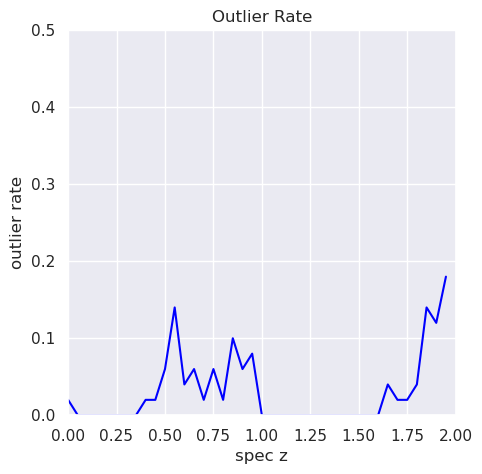

In [27]:
combined_outlier_array = np.transpose(np.vstack((specz, photoz, photoz_err)))
sorted_combined_outlier_array = sorted(combined_outlier_array, key = lambda x : x[0])
bins_outlier = int(z_max * 20)
splitted_sorted_combined_outlier_array = np.array_split(sorted_combined_outlier_array, bins_outlier)
outlier_array = []
outlier_count_total = 0
for i in range(0, bins_outlier):
    outlier_count = 0
    for j in range(0,len(splitted_sorted_combined_outlier_array[i])):
        if np.abs(splitted_sorted_combined_outlier_array[i][j][1] - splitted_sorted_combined_outlier_array[i][j][0]) >= 3 * splitted_sorted_combined_outlier_array[i][j][2]:
            outlier_count += 1
            outlier_count_total += 1
    outlier_array.append(outlier_count / len(specz) * bins_outlier)
x_array_outlier = np.arange(0, z_max, z_max / bins_outlier)
plt.plot(x_array_outlier, outlier_array, c = 'blue')
plt.title('Outlier Rate')
plt.xlabel('spec z')
plt.ylabel('outlier rate')
plt.xlim([0, z_max])
plt.ylim([0, 1/2])
plt.show()

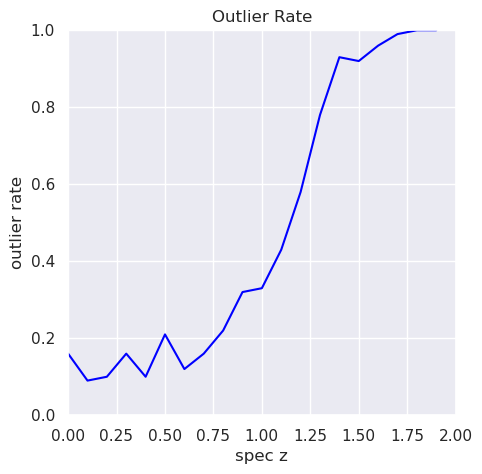

Outlier Rate: 0.478


In [28]:
combined_outlier_array = np.transpose(np.vstack((specz,np.subtract(photoz, specz))))
sorted_combined_outlier_array = sorted(combined_outlier_array, key = lambda x : x[0])
bins_outlier = int(z_max * 10)
splitted_sorted_combined_outlier_array = np.array_split(sorted_combined_outlier_array, bins_outlier)
outlier_array = []
outlier_count_total = 0
for i in range(0, bins_outlier):
    outlier_count = 0
    for j in range(0,len(splitted_sorted_combined_outlier_array[i])):
        if np.abs(splitted_sorted_combined_outlier_array[i][j][1] / (splitted_sorted_combined_outlier_array[i][j][0] + 1)) >= .15:
            outlier_count += 1
            outlier_count_total += 1
    outlier_array.append(outlier_count / len(specz) * bins_outlier)
x_array_outlier = np.arange(0, z_max, z_max /bins_outlier)
plt.plot(x_array_outlier, outlier_array, c = 'blue')
plt.title('Outlier Rate')
plt.xlabel('spec z')
plt.ylabel('outlier rate')
plt.xlim([0, z_max])
plt.ylim([0, 1])
plt.show()

print("Outlier Rate: "+str(outlier_count_total / len(specz)))

In [ ]:
# END